Scikit-learn HistGradientBoostingRegressor() model on MDA_dataframeArthur.csv.

Time Series cross-validation: 24h delay for weather, 1 month gap between train and test sets.
MAE en RMSE can be compared to other models.

In [27]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Dataframe is loaded, 24h-delayed noise is added. Datetime columns are dropped in order to run model.

In [28]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
#select only three locations close to Oude Markt
df = df[df['object_id']<255442]
df['255439'] = df['object_id']==255439
df['255440'] = df['object_id']==255440
df['255441'] = df['object_id']==255441
df = df.sort_values(by=['result_timestamp','object_id'])

Create unique key for each observation (necessary for merging after delaying noise and weather data)

In [29]:
df['key'] = df['object_id'].astype('str') + df['result_timestamp']
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'],format='%Y-%m-%d %H:%M:%S')

In [30]:
df_noisedelay = df[['object_id','result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(hours=6)
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay['key'] = df_noisedelay['object_id'].astype('str') + df_noisedelay['result_timestamp'].astype('str')
df_noisedelay = df_noisedelay.drop(['laeq','object_id','result_timestamp'], axis=1)

df_weatherdelay = df[['object_id','result_timestamp','LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                   'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']]
df_weatherdelay['result_timestamp'] = df_weatherdelay['result_timestamp']+pd.DateOffset(hours=6)
df_weatherdelay['key'] = df_weatherdelay['object_id'].astype('str') + df_weatherdelay['result_timestamp'].astype('str')
df_weatherdelay = df_weatherdelay.drop(['object_id','result_timestamp'], axis=1)
df = df.drop(['LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0'],axis=1)


C:\Users\Arthur\AppData\Local\Temp\ipykernel_7256\3475587407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(hours=6)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_7256\3475587407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
C:\Users\Arthur\AppData\Local\Temp\ipykernel_7256\3475587407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [31]:
df = pd.merge(df,df_noisedelay, on='key',validate='1:1')
df= pd.merge(df,df_weatherdelay, on='key',validate='1:1')
df_nd = df.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [32]:
df_nd.isna().sum()


laeq             0
hour             0
weekday          0
month            0
weekend          0
holiday          0
exam_period      0
255439           0
255440           0
255441           0
laeq_delayed     0
LC_HUMIDITY     19
LC_DWPTEMP      19
LC_n            19
LC_RAD          19
LC_RAININ       19
LC_DAILYRAIN    19
LC_WINDDIR      19
LC_WINDSPEED    19
LC_RAD60         1
LC_TEMP_QCL0    19
dtype: int64

In [33]:
df_nd = df_nd[df_nd.isna()['LC_HUMIDITY']==False]
df_nd.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [34]:
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Monday', value=0)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Tuesday', value=1)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Wednesday', value=2)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Thursday', value=3)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Friday', value=4)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Saturday', value=5)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Sunday', value=6)

The target dataset (y) and predictor dataset (X) are created.

In [35]:
y = df_nd["laeq"]
X = df_nd.drop("laeq", axis="columns")

In [36]:
#create time-sensitive split for cross-validation: gap = 1 month, train size = 1/5 of data set, test size = max
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=12960,
    max_train_size=26300,
    test_size=18347,
)

In [37]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,laeq_delayed,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
5,6,5,1,True,True,False,False,False,True,51.627045,90.0,11.72,38.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28
6,7,5,1,True,True,False,False,False,True,52.079000,90.0,11.62,37.0,0.0,0.0,0.0,56.0,0.02,0.0,13.28
7,7,5,1,True,True,False,False,False,True,53.478833,89.0,11.58,38.0,0.0,0.0,0.0,-24.0,0.02,0.0,13.28
8,7,5,1,True,True,False,False,False,True,51.713333,89.0,11.50,37.0,0.0,0.0,0.0,-50.0,0.08,0.0,13.28
9,7,5,1,True,True,False,False,False,True,50.654576,89.0,11.50,38.0,0.0,0.0,0.0,-79.0,0.05,0.0,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26300,7,0,4,False,True,False,False,False,True,45.189667,64.0,1.36,36.0,0.0,0.0,0.0,88.0,0.62,0.0,7.76
26301,7,0,4,False,True,False,True,False,False,39.574000,65.0,1.40,35.0,0.0,0.0,0.0,102.0,0.43,0.0,7.68
26302,7,0,4,False,True,False,False,True,False,39.047000,65.0,1.40,35.0,0.0,0.0,0.0,102.0,0.43,0.0,7.68
26303,7,0,4,False,True,False,False,False,True,45.855833,65.0,1.40,35.0,0.0,0.0,0.0,102.0,0.43,0.0,7.68


In [38]:
y

1         45.743000
2         48.452167
3         45.736167
4         44.955333
5         45.950833
            ...    
131013    53.712833
131014    55.333167
131015    56.797333
131016    61.010667
131017    58.354424
Name: laeq, Length: 130999, dtype: float64

In [39]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,laeq_delayed,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
73393,17,4,7,False,True,False,True,False,False,50.075000,45.0,12.16,32.0,547.0,0.0,0.000,118.0,0.35,526.0,24.81
73394,17,4,7,False,True,False,False,True,False,50.660833,45.0,12.16,32.0,547.0,0.0,0.000,118.0,0.35,526.0,24.81
73395,17,4,7,False,True,False,False,False,True,53.281833,45.0,12.16,32.0,547.0,0.0,0.000,118.0,0.35,526.0,24.81
73396,17,4,7,False,True,False,True,False,False,54.822667,44.0,12.07,32.0,564.0,0.0,0.000,-162.0,0.13,533.0,25.15
73397,17,4,7,False,True,False,False,True,False,54.166000,44.0,12.07,32.0,564.0,0.0,0.000,-162.0,0.13,533.0,25.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99697,14,2,9,False,False,False,True,False,False,55.064500,94.0,8.51,32.0,32.0,0.0,0.003,85.0,0.01,29.0,9.34
99698,14,2,9,False,False,False,False,True,False,56.716333,94.0,8.51,32.0,32.0,0.0,0.003,85.0,0.01,29.0,9.34
99699,14,2,9,False,False,False,False,False,True,57.149000,94.0,8.51,32.0,32.0,0.0,0.003,85.0,0.01,29.0,9.34
99700,14,2,9,False,False,False,True,False,False,55.228167,93.0,8.45,32.0,34.0,0.0,0.003,-5.0,0.00,28.0,9.61


In [40]:
# grid search for hyperparameter tuning
param_grid = {
    'learning_rate': (0.04,0.05,0.06),
    'max_leaf_nodes': (8,9,10)}
model = GradientBoostingRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=12960, max_train_size=26300, n_splits=5, test_size=18347),
             estimator=GradientBoostingRegressor(), n_jobs=2,
             param_grid={'learning_rate': (0.04, 0.05, 0.06),
                         'max_leaf_nodes': (8, 9, 10)})

In [41]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.63


In [42]:
model_grid_search.predict(X.iloc[0:5])

array([49.04657395, 49.02951617, 49.04657395, 48.44543321, 48.30328863])

In [43]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.05, 'max_leaf_nodes': 9}


In [44]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,11.572232,0.177255,0.041097,0.005366,0.05,9,"{'learning_rate': 0.05, 'max_leaf_nodes': 9}",0.490604,0.646866,0.727782,-0.029915,0.199060,0.406879,0.283394,1
6,11.697057,0.189093,0.037717,0.000405,0.06,8,"{'learning_rate': 0.06, 'max_leaf_nodes': 8}",0.503519,0.652580,0.730323,-0.014631,0.158885,0.406135,0.287574,2
8,11.918185,0.371647,0.045997,0.005325,0.06,10,"{'learning_rate': 0.06, 'max_leaf_nodes': 10}",0.503519,0.652580,0.730323,-0.016842,0.158885,0.405693,0.288221,3
5,12.195086,0.798949,0.039003,0.001680,0.05,10,"{'learning_rate': 0.05, 'max_leaf_nodes': 10}",0.490604,0.646866,0.727782,-0.048293,0.199060,0.403204,0.289097,4
7,11.634637,0.177357,0.041202,0.006235,0.06,9,"{'learning_rate': 0.06, 'max_leaf_nodes': 9}",0.503519,0.652580,0.730323,-0.032070,0.158885,0.402647,0.292716,5


In [45]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [46]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
4,0.05,9,0.406879,0.283394,1
6,0.06,8,0.406135,0.287574,2
8,0.06,10,0.405693,0.288221,3
5,0.05,10,0.403204,0.289097,4
7,0.06,9,0.402647,0.292716,5
1,0.04,9,0.402550,0.280498,6
3,0.05,8,0.402263,0.290569,7
2,0.04,10,0.402029,0.281339,8
0,0.04,8,0.398614,0.286881,9


In [47]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_max_leaf_nodes"])

pivoted_cv_results

param_max_leaf_nodes,8,9,10
param_learning_rate,,,
0.04,0.398614,0.402550,0.402029
0.05,0.402263,0.406879,0.403204
0.06,0.406135,0.402647,0.405693


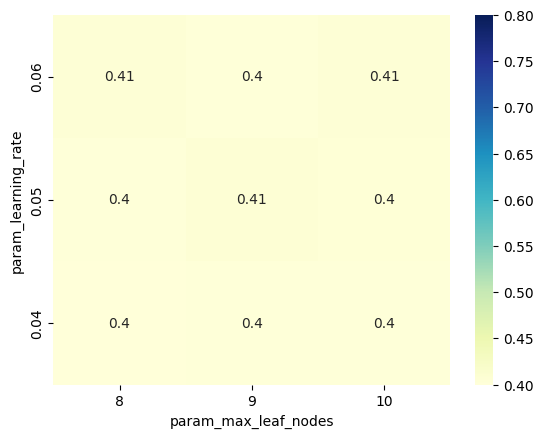

In [48]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

Mean Absolute Error:     2.768 +/- 0.548
Root Mean Squared Error: 3.902 +/- 0.851


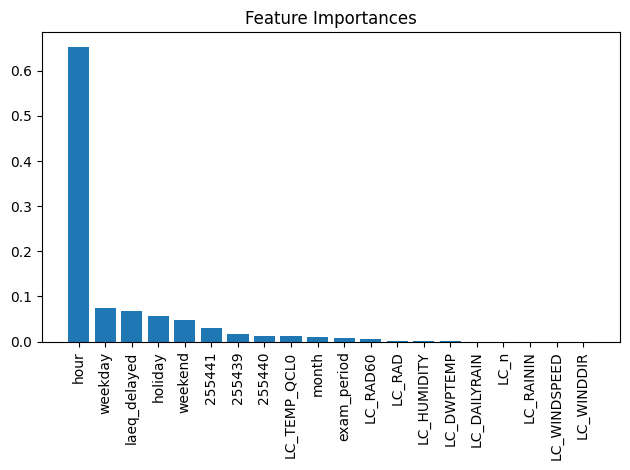

In [49]:
#run gradient boosting model and plot feature importances
import numpy as np
import matplotlib.pyplot as plt

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

    # Fit the model on the data
    model.fit(X, y)

    # Retrieve feature importances
    feature_importances = model.named_steps['gradientboostingregressor'].feature_importances_
    feature_names = X.columns

    # Sort feature importances in descending order
    indices = np.argsort(feature_importances)[::-1]

    # Plot feature importances
    plt.figure()
    plt.title('Feature Importances')
    plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation='vertical')
    plt.tight_layout()
    plt.show()

gbrt_pipeline = make_pipeline(GradientBoostingRegressor(max_leaf_nodes=9, learning_rate=0.05))
evaluate(gbrt_pipeline, X, y, cv=ts_cv)


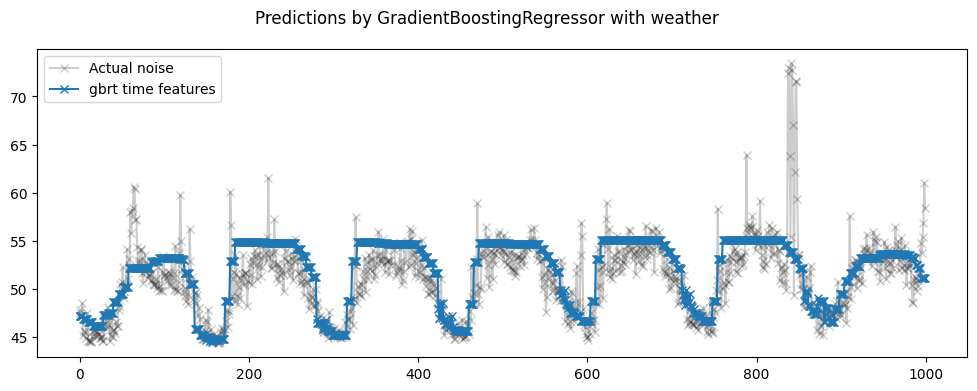

In [50]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X, y)
gbrt_predictions = gbrt_pipeline.predict(X)

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by GradientBoostingRegressor with weather")
ax.plot(
    y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


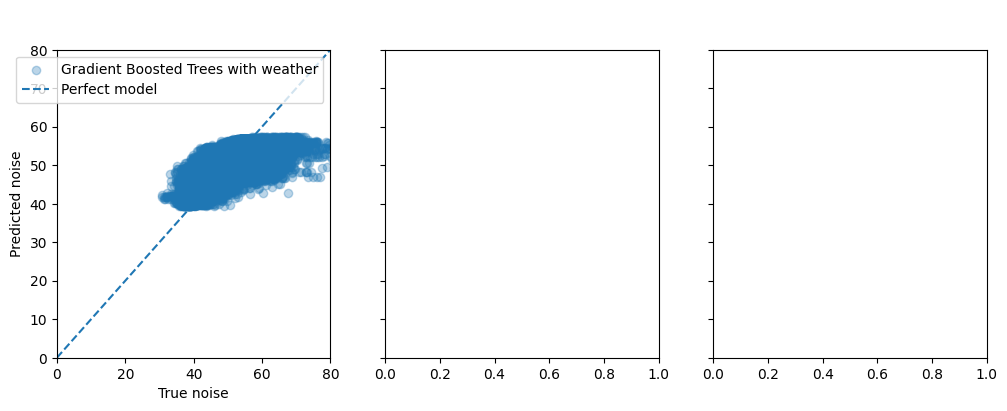

In [51]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle(" ")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True noise",
        ylabel="Predicted noise",
    )
    ax.legend()

plt.show()

In [52]:
#predict nighttime values only
df_night = df.set_index('result_timestamp')

In [53]:
df_night = df_night.between_time(start_time='22:00:00', end_time='6:00:00', inclusive='left')
df_night = df_night.reset_index()
df_nd_n = df_night.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [54]:
df_nd_n = df_nd_n[df_nd_n.isna()['LC_HUMIDITY']==False]
df_nd_n.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [55]:
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Monday', value=0)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Tuesday', value=1)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Wednesday', value=2)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Thursday', value=3)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Friday', value=4)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Saturday', value=5)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Sunday', value=6)

In [56]:
y_night = df_nd_n["laeq"]
X_night = df_nd_n.drop("laeq", axis="columns")

In [57]:
predictions = gbrt_pipeline.predict(X_night)
predictions

array([52.92508254, 52.92508254, 52.92508254, ..., 51.16399268,
       51.16399268, 51.16399268])

In [58]:
MAE = sum(((predictions-y_night)**2)**(1/2))/len(y_night)
MAE

2.8182937993204478

In [59]:
RMSE = (sum((predictions-y_night)**2)/len(y_night))**(1/2)
RMSE

3.9318577718723073